# African Radio Interferometry Winter School 2019

North-West University, Potchefstroom  
daniel.czech@protonmail.com  
27 Jun 2019  

## Setup

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import specgram
from scipy import signal
import matplotlib as mpl
from sklearn.decomposition import KernelPCA

from mpl_toolkits.mplot3d import Axes3D
mpl.rcParams['agg.path.chunksize'] = 10000

mpl.rcParams['figure.dpi'] = 300

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

mpl.rcParams['figure.figsize'] = [5, 3]

## Load the data

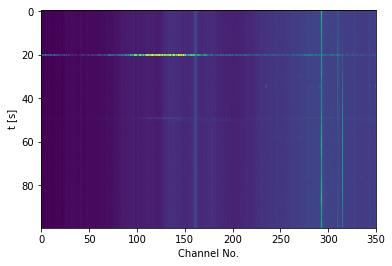

In [3]:
spectra = np.load('TF_data.npy')
plt.imshow(spectra, aspect = 'auto')
plt.xlabel('Channel No.')
plt.ylabel('t [s]')
plt.show()

Incidentally, this file is a subset of a larger hdf5 file produced by the original RATTY monitor at the KAT-7 site.  
For more information:  
https://open.uct.ac.za/handle/11427/17396  
Schollar, Christopher. RFI monitoring for the MeerKAT radio telescope. Diss. University of Cape Town, 2015.

## Basic thresholding

First, we will attempt to apply a simple threshold to the data. Before doing so, it might be useful to plot a histogram as follows:

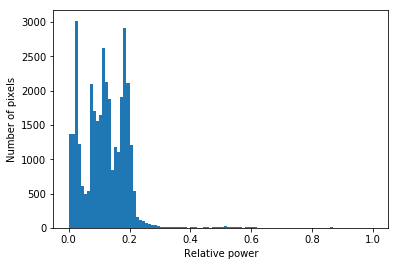

In [4]:
plt.hist(spectra.flatten(), bins=100)
plt.xlabel('Relative power')
plt.ylabel('Number of pixels')
plt.show()

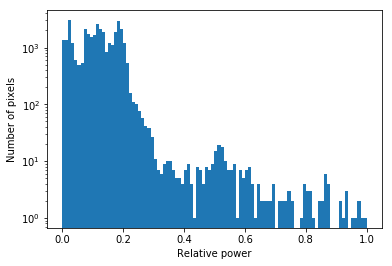

In [5]:
plt.hist(spectra.flatten(), bins=100)
plt.xlabel('Relative power')
plt.ylabel('Number of pixels')
ax = plt.gca()
ax.set_yscale('log')
plt.show()

Now, we can experiment with placing a threshold:

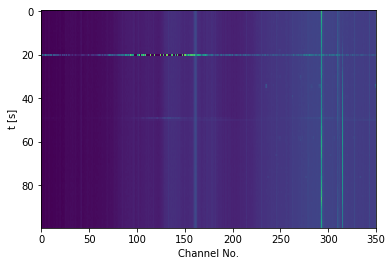

In [11]:
threshold = 0.8

spectra = np.load('TF_data.npy')
threshold_indices = spectra > threshold
spectra[threshold_indices] = 0
plt.imshow(spectra, aspect = 'auto', vmin = 0, vmax = 1)
plt.xlabel('Channel No.')
plt.ylabel('t [s]')
plt.show()

OK, but this is only a small part of the band. What happens if we look at the rest of the band too?

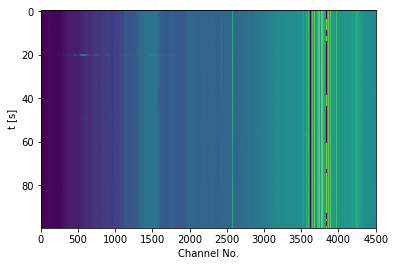

In [12]:
spectra = np.load('TF_data_long.npy')
threshold_indices = spectra > threshold
spectra[threshold_indices] = 0
plt.imshow(spectra, aspect = 'auto', vmin = 0, vmax = 1)
plt.xlabel('Channel No.')
plt.ylabel('t [s]')
plt.show()

Why has this happened?

Fortunately, alternative flagging methods exist:

## Median Absolute Deviation (MAD)
  
Typically applied as a moving window in frequency.

$$MAD = median(|X_i - median(X)|) $$ 

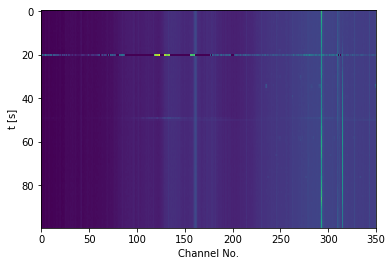

In [14]:
MAD_threshold = 0.05
window_size = 9

spectra = np.load('TF_data.npy')
mid_val = (window_size - 1)/2
num_windows = spectra.shape[1] - window_size + 1
MAD = np.zeros(spectra.shape)

for i in range(mid_val, spectra.shape[1] - mid_val):
    windows_i = spectra[:,i - mid_val:i + mid_val]
    medians_i = np.median(windows_i, axis = 1).reshape(windows_i.shape[0], 1)
    MAD[:,i] = np.median(np.abs(np.subtract(windows_i, medians_i)), axis = 1)

threshold_indices = MAD > MAD_threshold    
spectra[threshold_indices] = 0

plt.imshow(spectra, aspect = 'auto', vmin = 0, vmax = 1)
plt.xlabel('Channel No.')
plt.ylabel('t [s]')
plt.show()

## Spectral Kurtosis

Kurtosis is a measure of how peaked or how flattened a symmetric distribution is compared with a Gaussian distribution.  

<img src="Kurtosis.jpg" style="width: 300px;"/>

It is calculated as follows:
    
$$ Kurt[X] = \frac{E[(X-\mu)^4]}{(E[(X-\mu)^2])^2} $$

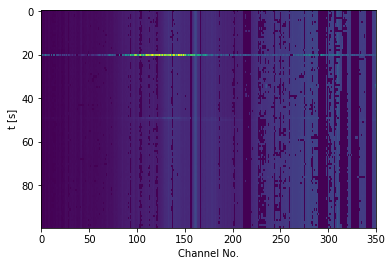

In [18]:
SK_threshold = 3.9
window_size = 10

spectra = np.load('TF_data.npy')
mid_val = (window_size-1)/2
num_windows = spectra.shape[1]-window_size+1
SK = np.zeros(spectra.shape)

for i in range(mid_val, spectra.shape[1] - mid_val):
    windows_i = spectra[:,i - mid_val:i + mid_val]
    means_i = np.mean(windows_i, axis = 1).reshape(windows_i.shape[0], 1)
    numerator = np.mean(np.power(np.subtract(windows_i, means_i), 4), axis = 1)
    denominator = np.power(np.mean(np.power(np.subtract(windows_i, means_i), 2), axis = 1), 2)
    SK[:,i] = np.divide(numerator, denominator)
    
threshold_indices = SK > SK_threshold    
spectra[threshold_indices] = 0

plt.imshow(spectra, aspect = 'auto', vmin = 0, vmax = 1)
plt.xlabel('Channel No.')
plt.ylabel('t [s]')
plt.show()

Note that _spectral_ kurtosis is effective against CW RFI, but not transient RFI.  
How about _temporal_ kurtosis?

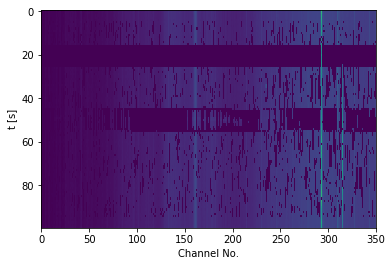

In [9]:
TK_threshold = 3.4
window_size = 11

spectra = np.load('TF_data.npy')
mid_val = (window_size-1)/2
num_windows = spectra.shape[0]-window_size+1
TK = np.zeros(spectra.shape)

for i in range(mid_val, spectra.shape[0] - mid_val):
    windows_i = spectra[i - mid_val:i + mid_val, :]
    means_i = np.mean(windows_i, axis = 0).reshape(1, windows_i.shape[1])
    numerator = np.mean(np.power(np.subtract(windows_i, means_i), 4), axis = 0)
    denominator = np.power(np.mean(np.power(np.subtract(windows_i, means_i), 2), axis = 0), 2)
    TK[i,:] = np.divide(numerator, denominator)
    
threshold_indices = TK > TK_threshold    
spectra[threshold_indices] = 0

plt.imshow(spectra, aspect = 'auto', vmin = 0, vmax = 1)
plt.xlabel('Channel No.')
plt.ylabel('t [s]')
plt.show()

Have a look at the excised area around the strong transient RFI at $t = 20s$. Why is the excised area so much thicker than the streak of transient RFI?

## Looking for distant astronomical sources: ZeroDM filtering

The idea behind ZeroDM filtering is that transient (narrowband) RFI from nearby terrestrial sources should exhibit a dispersion of 0. 

In this approach, the mean of each spectrum in a time-frequency plot is simply subtracted from each sample in the spectrum, thus supressing undispersed signals. From [1], 

$$S'(f_i, t_j) = S(f_i, t_j) - \frac{1}{n_{channels}} \sum_{i=1}^{n_{channels}}S(f_i,t_j)$$

[1] Eatough, R. P., Keane, E. F., & Lyne, A. G. (2009). An interference removal technique for radio pulsar searches. Monthly Notices of the Royal Astronomical Society, 395(1), 410-415.  
  
This is implemented below.

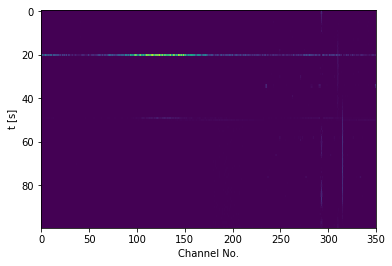

In [10]:
spectra = np.load('TF_data.npy')

filtered_spec = np.subtract(spectra, np.mean(spectra, axis=0))

plt.imshow(filtered_spec, aspect = 'auto', vmin = 0, vmax = 1)
plt.xlabel('Channel No.')
plt.ylabel('t [s]')
plt.show()

Note that even though the undispersed CW RFI has been suppressed, the highly broad-band RFI pulse has been let through.

It is possible, however, to find examples of RFI sources that appear to exhibit dispersion.  

One example is from a microwave oven. Here is a signal recorded from a microwave oven in the lab:  

(5001, 303)


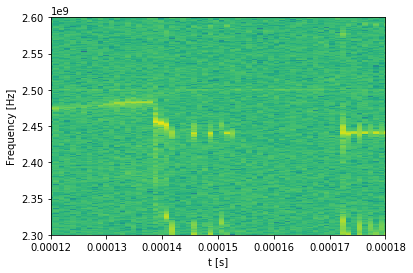

In [11]:
signal = np.load('signal2.npy')
sample_length = 1.0/1600000000.0
x_points = np.linspace(0,len(signal)-1,len(signal))*sample_length*1000000.0
spec, freq, t, im  = specgram(signal, Fs=10e9, scale_by_freq = False, NFFT = 10000)
print spec.shape
plt.ylabel('Frequency [Hz]')
plt.xlabel('t [s]')
plt.ylim([2.3e9,2.6e9])
plt.xlim([0.00012,0.00018])
plt.show()

Applying ZeroDM filtering:

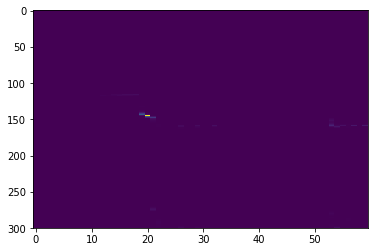

In [13]:
filtered_spec = np.subtract(spec, np.mean(spec, axis=0))
plt.imshow(np.flip(filtered_spec[2300:2600,121:181], 0), aspect = 'auto')
plt.show()

# Artificial Example: RFI Classification

This section provides a somewhat artificial example using kernel principal components analysis to distinguish between transient RFI and natural astronomical transients.

To represent terrestrial transients, some recorded examples of transient RFI are used. Natural astronomical transients are represented by 
signals from the millisecond pulsar J0437-4715.

6 individual pulsar signals
50 individual RFI signals


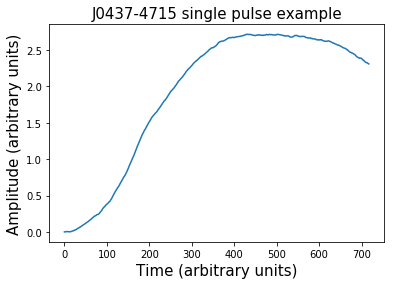

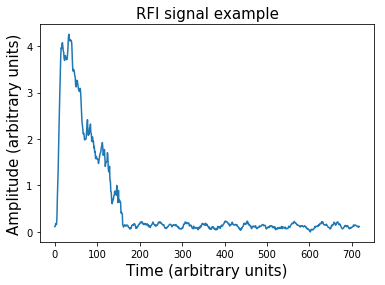

In [14]:
pulsars = np.load('J0437-4715.npy')
RFI = np.load('RFI1.npy')

print(str(pulsars.shape[0]) + ' individual pulsar signals')
print(str(RFI.shape[0]) + ' individual RFI signals')

num_pulsars = pulsars.shape[0]

plt.plot(pulsars[3,:])
plt.title('J0437-4715 single pulse example', size = 15)
plt.ylabel('Amplitude (arbitrary units)', size = 15)
plt.xlabel('Time (arbitrary units)', size = 15)
plt.show()

plt.plot(RFI[4,:])
plt.title('RFI signal example', size = 15)
plt.ylabel('Amplitude (arbitrary units)', size = 15)
plt.xlabel('Time (arbitrary units)', size = 15)
plt.show()

Principal Components Analysis (PCA) and kernel PCA:
    
Standard PCA transforms the data into a new coordinate system of orthogonal axes. The coordinates are ordered by the amount of the variance they explain. Components accounting for very small amounts of variance can be discarded, reducing the total number of features.

<img src="PCA2.png" style="width: 300px;"/>

Kernel PCA maps the data into a higher-dimensional space via a kernel function:
    
$$K(x,x) = \phi(x)\phi(x)^T$$

It makes use of the fact that it is easier to linearly separate clusters in higher dimensions. A common kernel function 
is the radial basis function:

$$K(x,y) = e^{-\gamma||x-y||^2}$$

For a good explanation of kernel PCA, refer to: https://sebastianraschka.com/Articles/2014_kernel_pca.html

In [15]:
X = np.vstack((pulsars,RFI))
kpca = KernelPCA()
components = kpca.fit_transform(X)

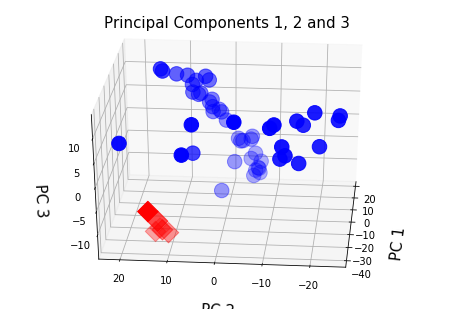

In [16]:
fig3d=plt.figure()
ax=Axes3D(fig3d)

ax.scatter(components[0:num_pulsars,0], components[0:num_pulsars,1], components[0:num_pulsars,2], c = 'r', s=210, marker = 'D', label = 'Pulsar Signals')            
ax.scatter(components[num_pulsars:,0], components[num_pulsars:,1], components[num_pulsars:,2], c = 'b', s=210, marker = 'o', label = 'RFI Transients')

ax.set_title("Principal Components 1, 2 and 3", size = 15)
ax.set_xlabel('\nPC 1', linespacing=2.5, size = 15)
ax.set_ylabel('\nPC 2', linespacing=2.5, size = 15)
ax.set_zlabel('\nPC 3', linespacing=2.5, size = 15)
ax.view_init(azim=185)

plt.show()

Applying kernel PCA to the data and visualising only the first three components, we can see that the RFI signals are well
separated from the pulsar signals. This simple example provides a best-case scenario.